In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys
import matplotlib.pylab as pylab
import time
import numpy as np
import seaborn as sns
sns.set_theme(style="white")
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import yaml
import os


new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)
from src.utils import *
import src.utils as ut

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

PATH2 = ''

In [2]:
with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE = yaml.safe_load(file)

PATHS =YAML_FILE['paths']

PATH_FEATURES_TRAIN = PATHS['PATH_FEATURES_TRAIN']
PATH_FEATURES_TEST = PATHS['PATH_FEATURES_TEST']

PATH2 = PATHS['PATH_LIGHT_CURVES_OGLE']

lc_test = pd.read_table(PATH_FEATURES_TEST, sep= ',')
lc_test = lc_test[lc_test.label=='ClassA']
lc_train = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')
lc_train = lc_train[lc_train.label=='ClassA']

In [3]:
example_test  = lc_test['ID'].sample(20)
example_train = lc_train['ID'].sample(20)

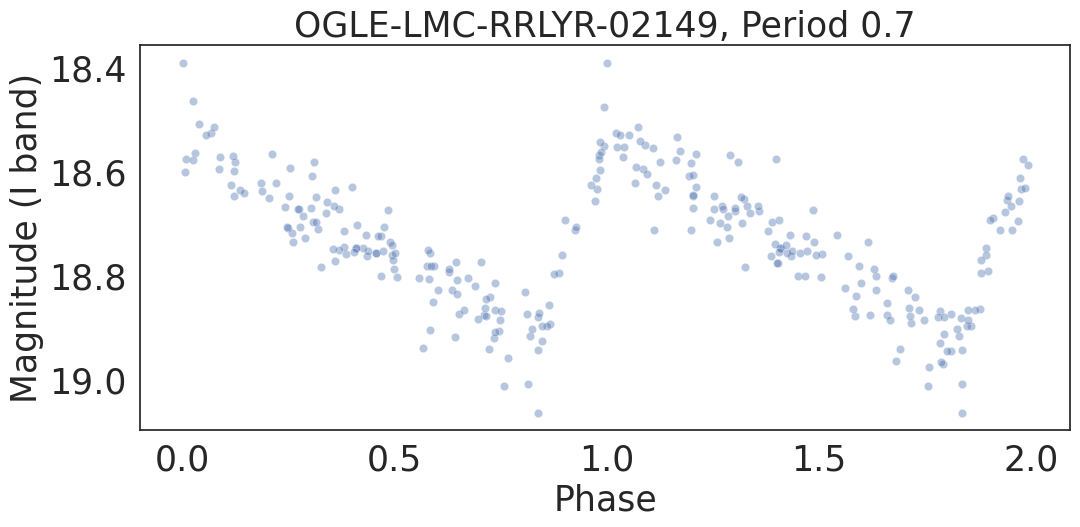

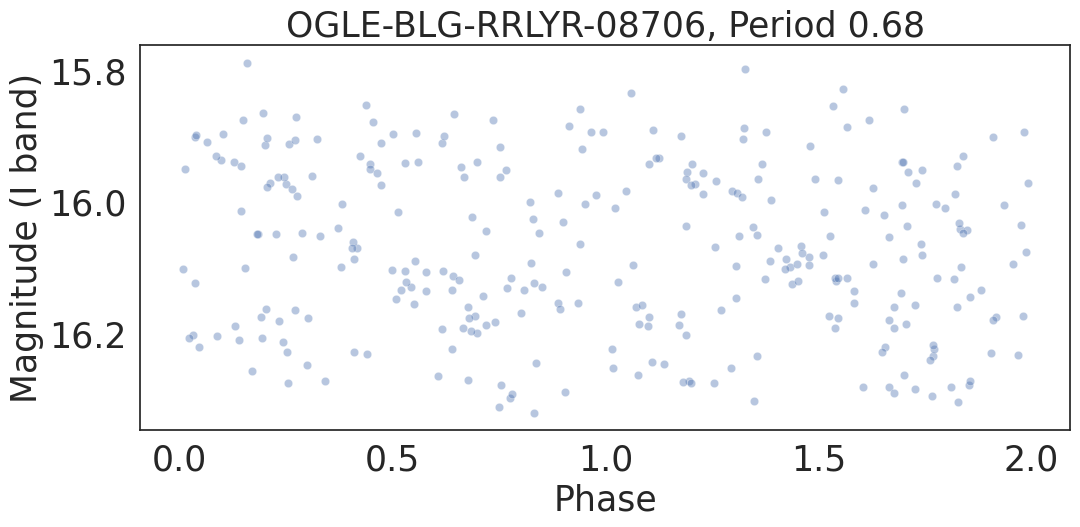

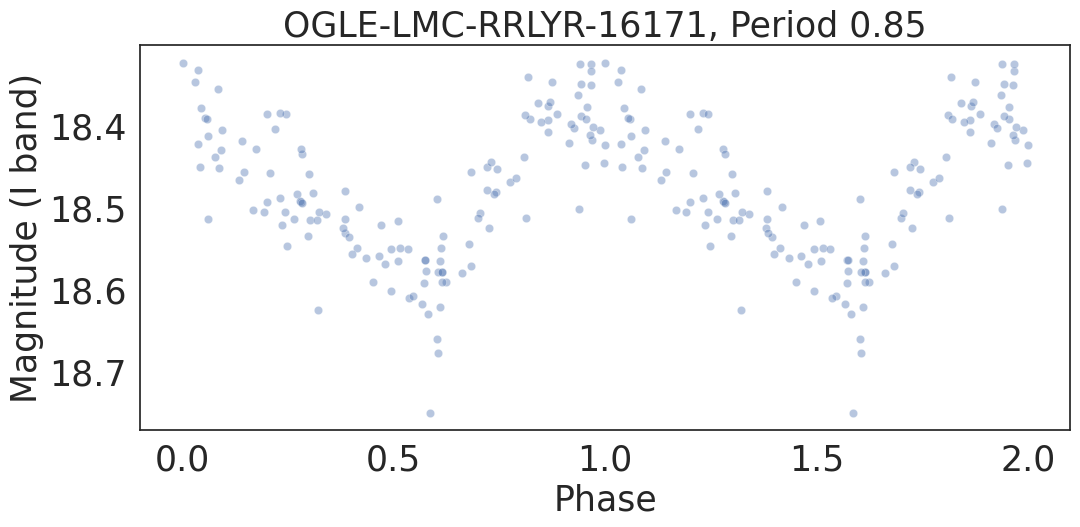

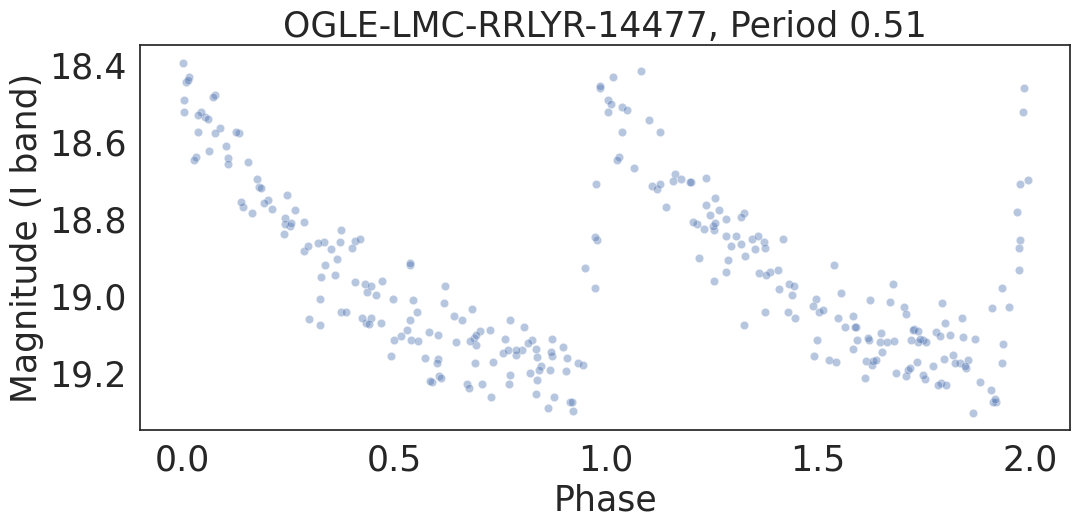

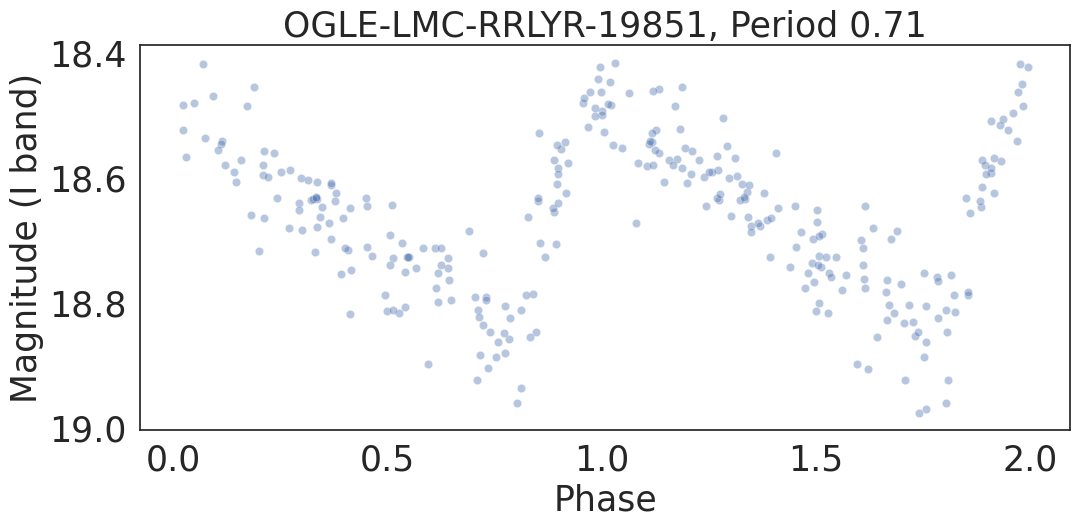

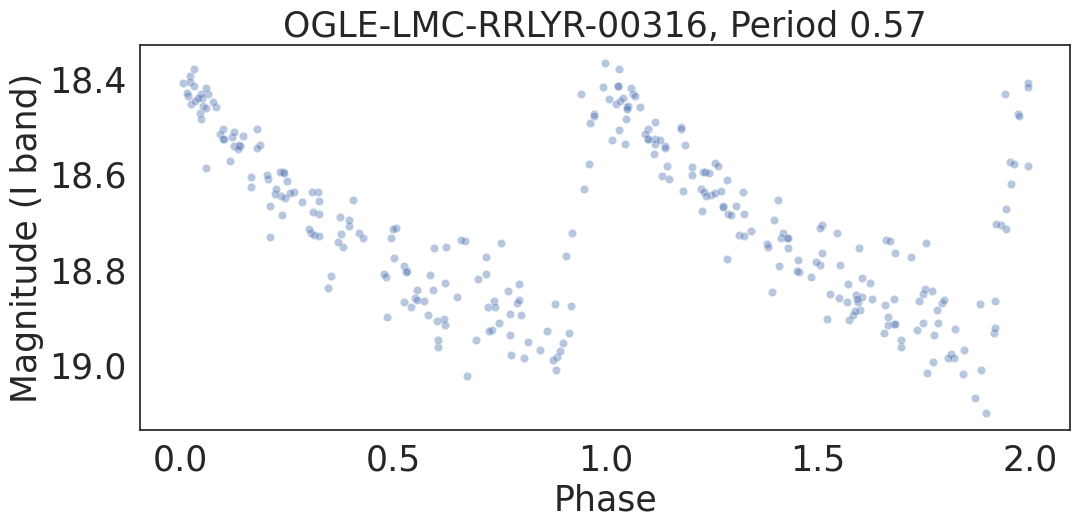

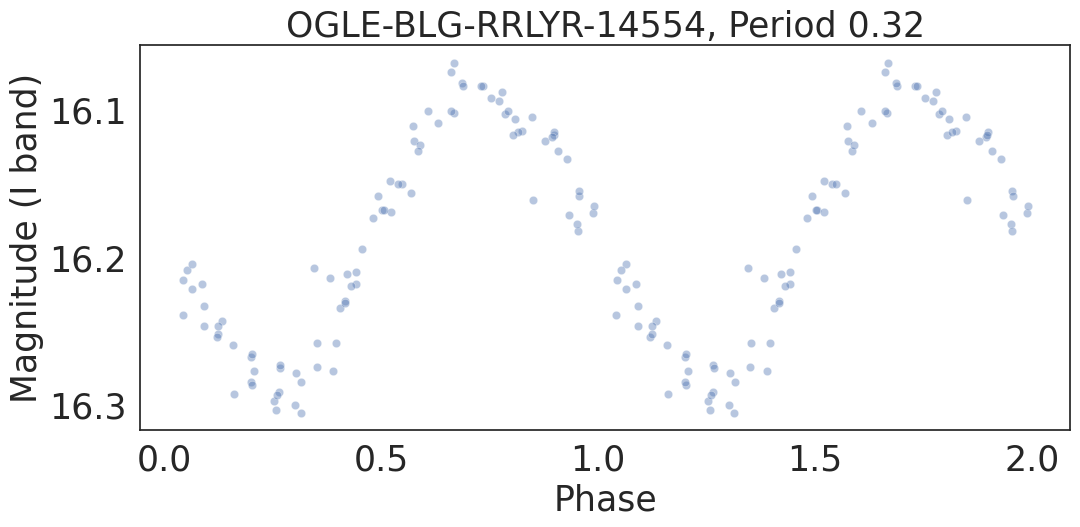

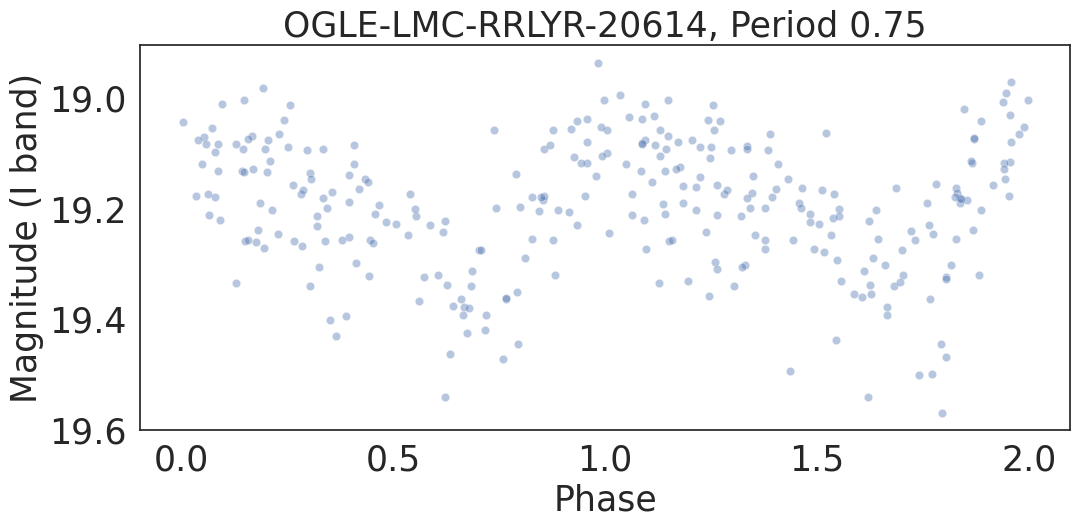

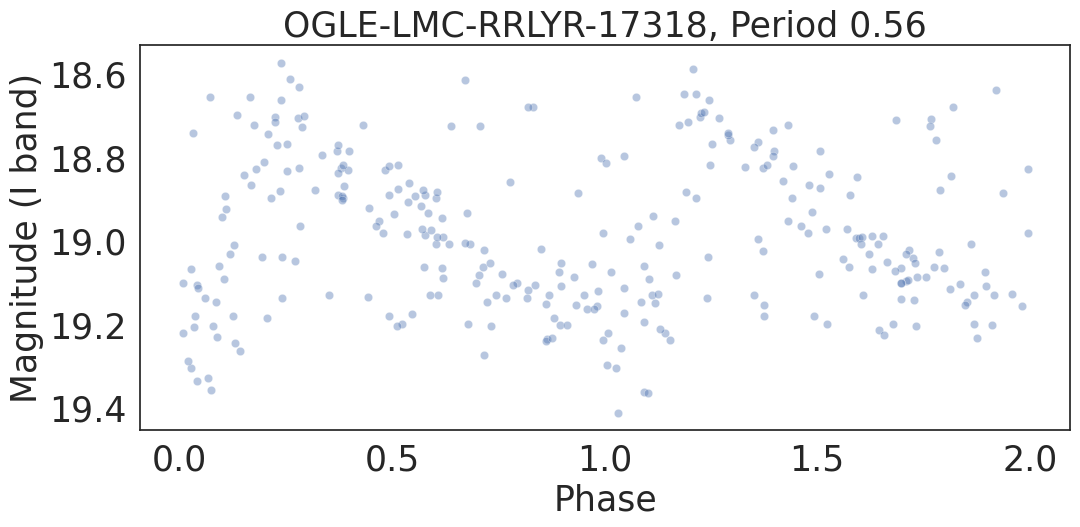

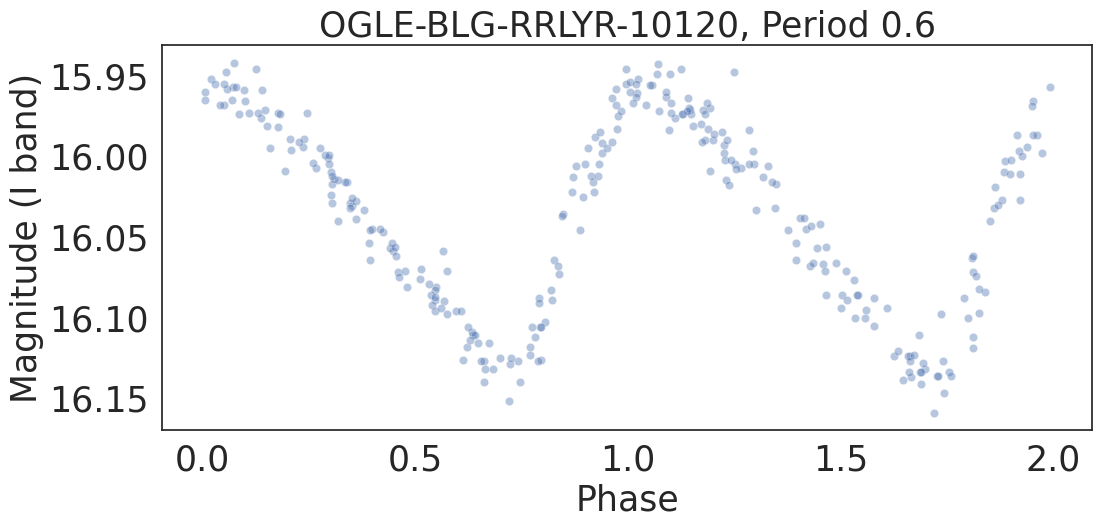

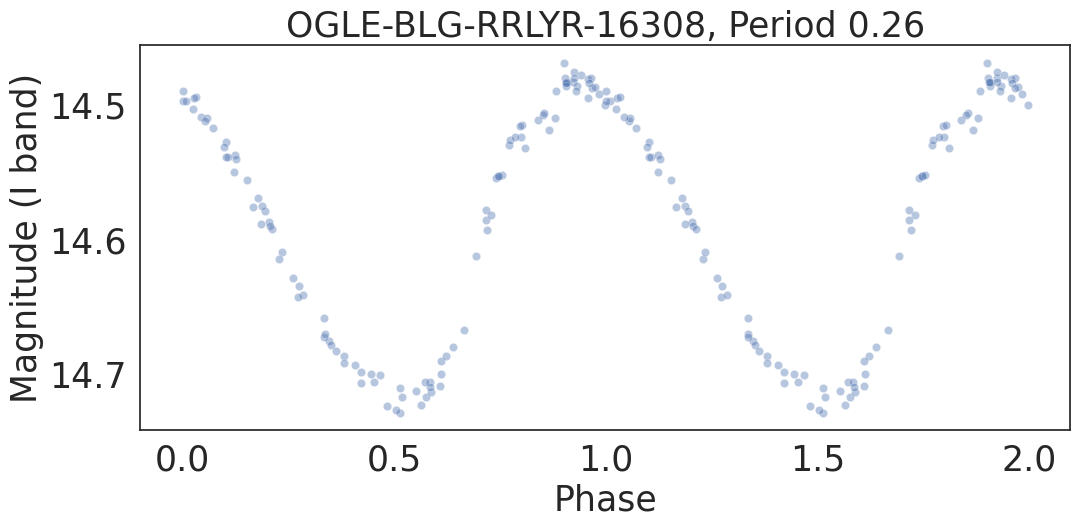

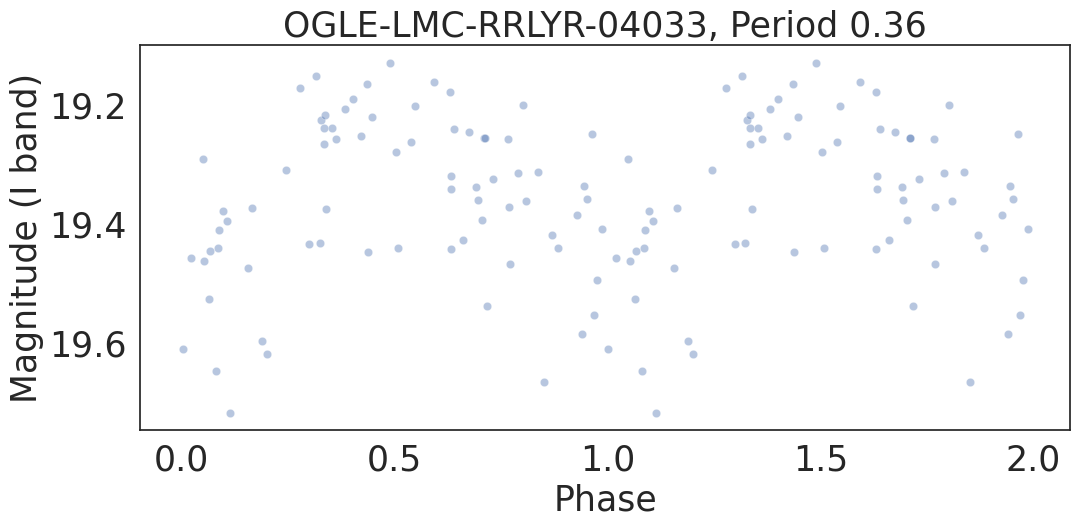

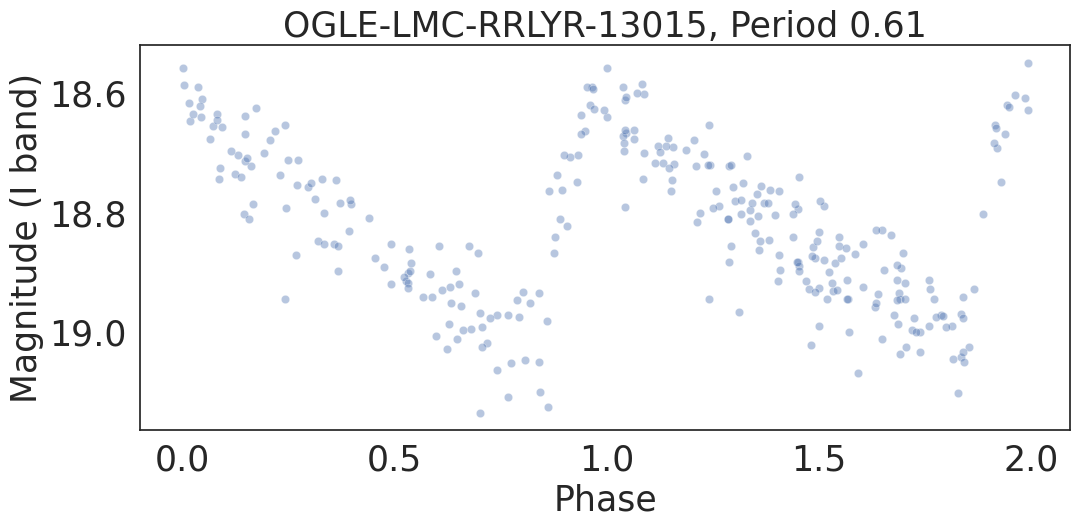

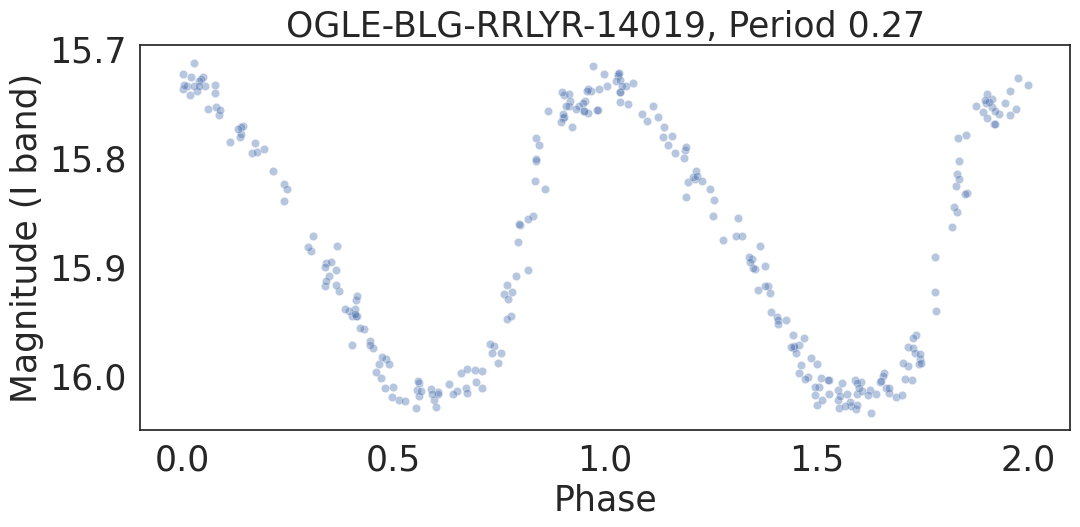

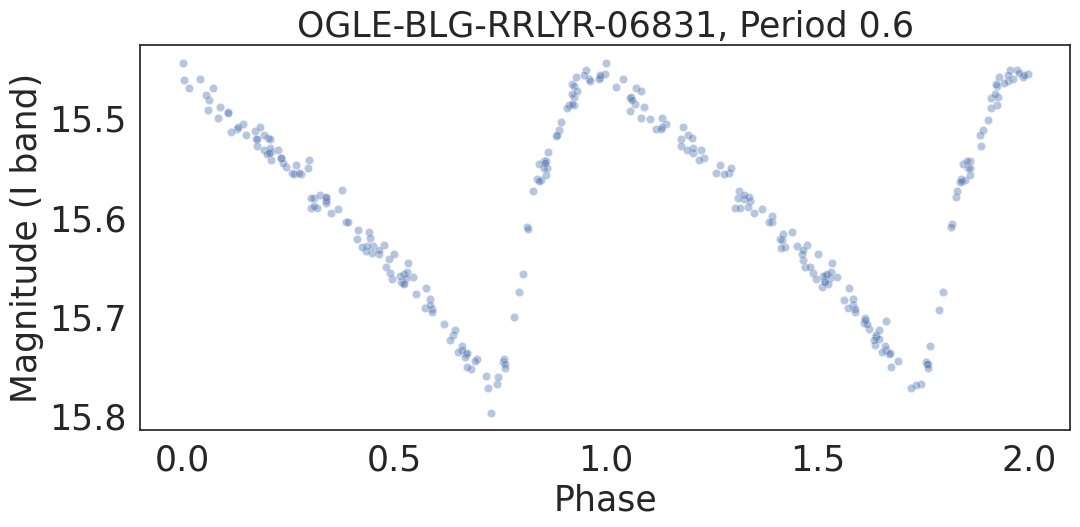

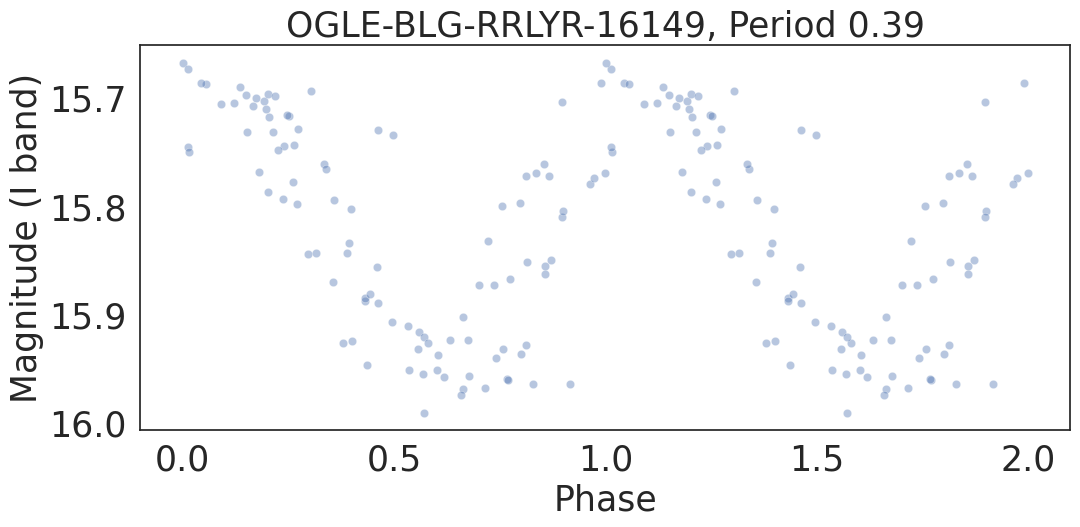

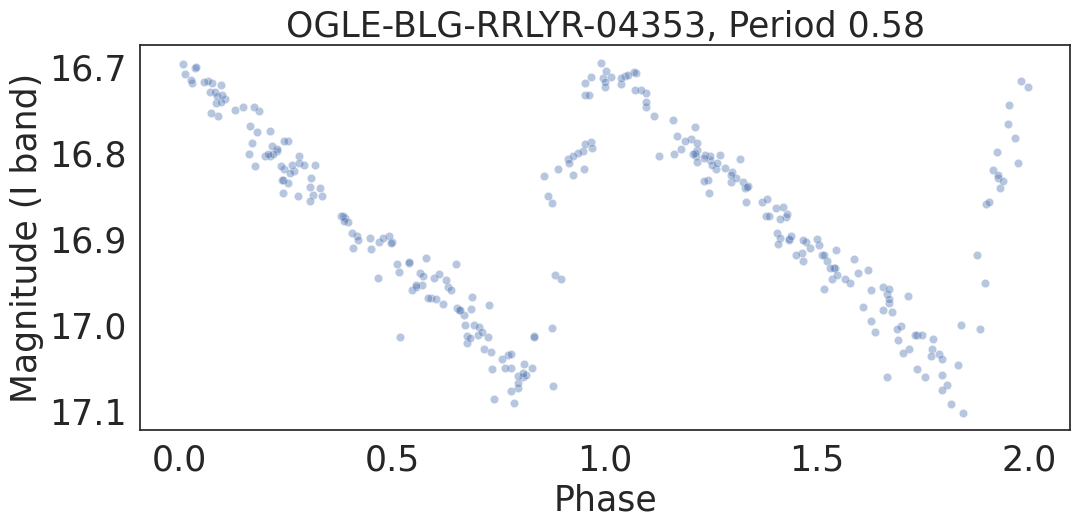

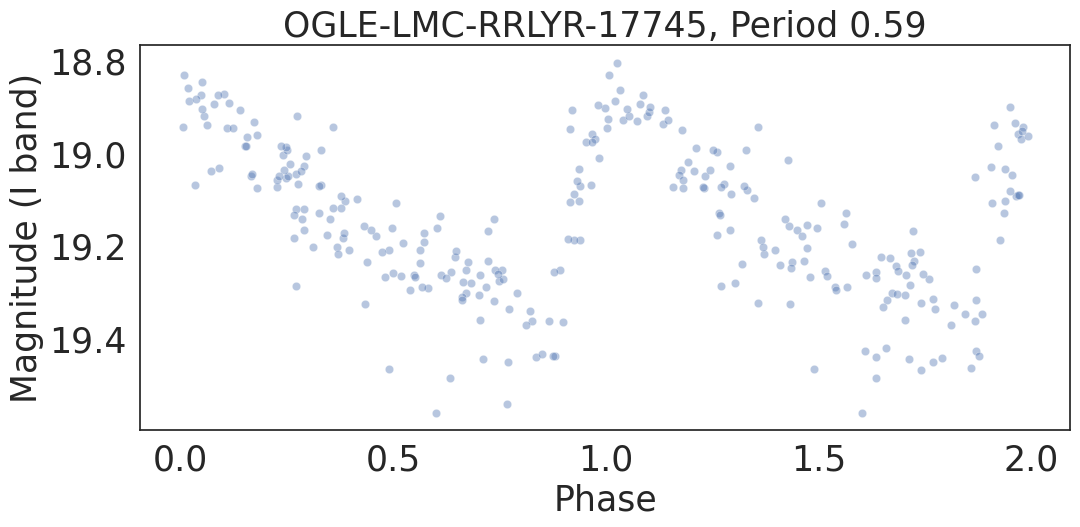

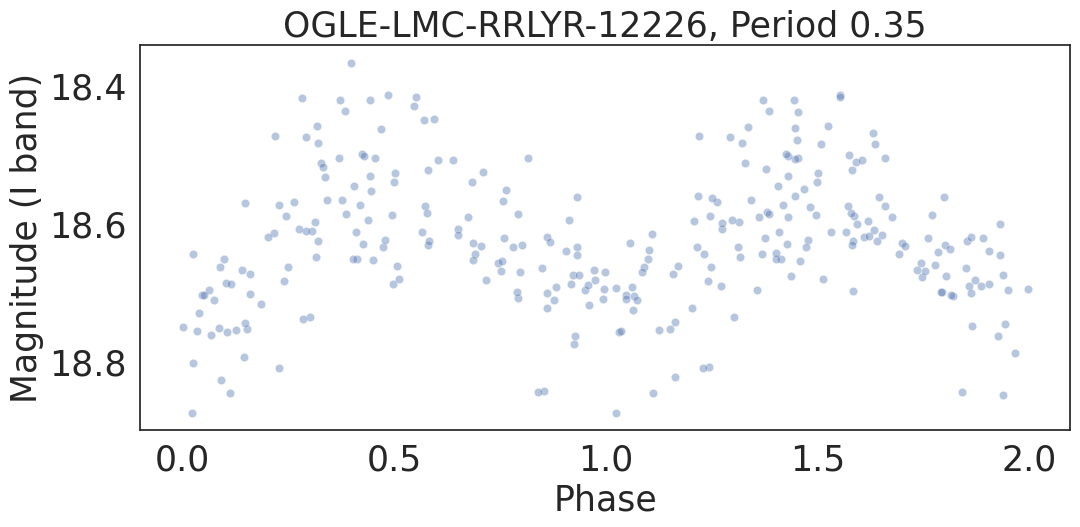

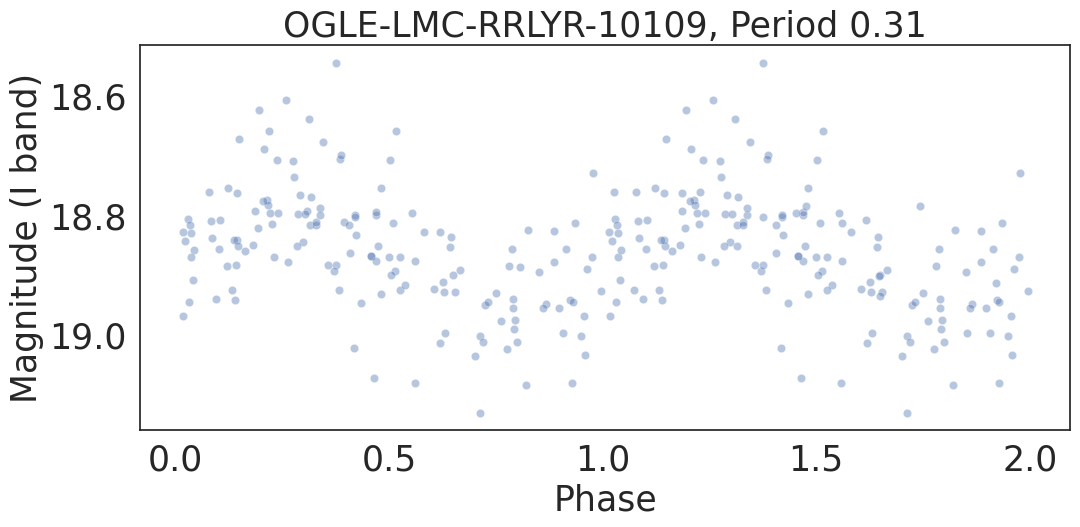

In [4]:
counter = 1 

for lc in example_test.unique():
    try:
        new_test = lc_test[lc_test.ID==lc].ID.str.split("-", n = 3, expand = True)
        
        period = lc_test[lc_test.ID==lc].PeriodLS.values[0]
        field = new_test[new_test.columns[1]].values[0].lower()
        
        lcu = pd.read_table(PATH2+field+'/'+lc.split('-')[2].lower()+'/phot/I/'+lc,sep=" ", names=['time', 'magnitude', 'error'])
        
        m0 = lcu.magnitude.min()
        t0 = lcu[lcu.magnitude==m0].time.min()
        lcu['Phase'] = ((lcu.time-t0)/period)%1 
        lcu = lcu.dropna()

        lcu2 =  lcu.copy()
        lcu2['Phase'] = lcu2['Phase']+1
        lcu = pd.concat([lcu,lcu2])
        sample = 300
        if lcu.dropna().shape[0]<300: 
            sample=lcu.dropna().shape[0]
        fig, ax=plt.subplots(figsize=(12, 5))
        sns.scatterplot(x="Phase", y="magnitude",
                 data=lcu.dropna().sample(sample), alpha =0.4, palette = 'colorblind')
        plt.title( str(lc).replace('.dat', '') + ', Period ' + str(np.round(period,2)))
        plt.ylabel('Magnitude (I band)')

        ax.invert_yaxis()
        plt.savefig('test'+str(counter)+'.svg', format='svg', bbox_inches='tight')
        counter = counter + 1

    except Exception as error:
        print(error)

OGLE-LMC-RRLYR-06937.dat
OGLE-BLG-RRLYR-01937.dat
OGLE-LMC-RRLYR-11615.dat
OGLE-BLG-RRLYR-12560.dat
OGLE-BLG-RRLYR-14045.dat
OGLE-LMC-RRLYR-12374.dat
OGLE-LMC-RRLYR-19955.dat
OGLE-LMC-RRLYR-21801.dat
OGLE-LMC-RRLYR-07278.dat
OGLE-LMC-RRLYR-03611.dat
OGLE-LMC-RRLYR-03299.dat
OGLE-BLG-RRLYR-14849.dat
OGLE-BLG-RRLYR-03442.dat
OGLE-LMC-RRLYR-15296.dat
OGLE-LMC-RRLYR-11498.dat
OGLE-LMC-RRLYR-24100.dat
OGLE-BLG-RRLYR-08248.dat
OGLE-BLG-RRLYR-02599.dat
OGLE-LMC-RRLYR-06330.dat
OGLE-LMC-RRLYR-05616.dat


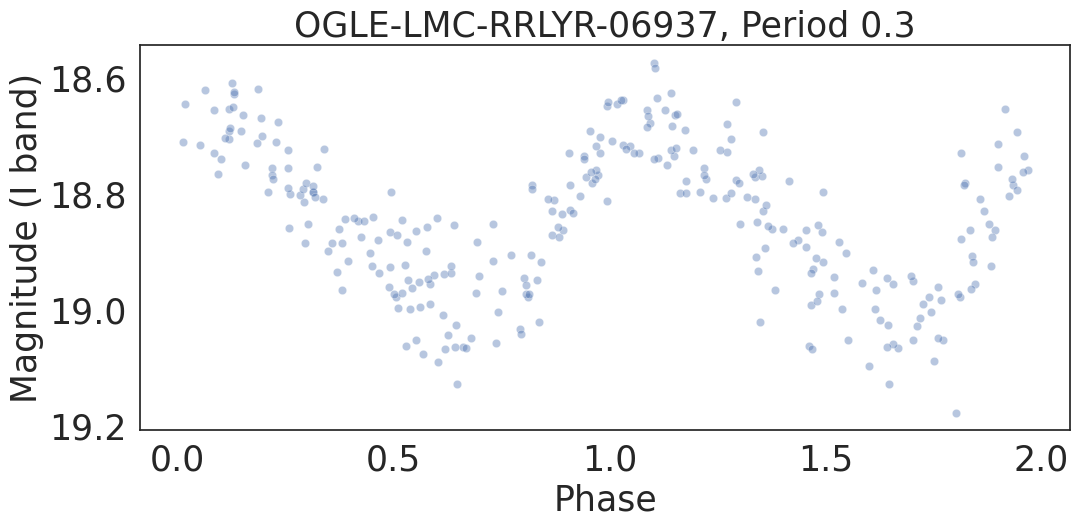

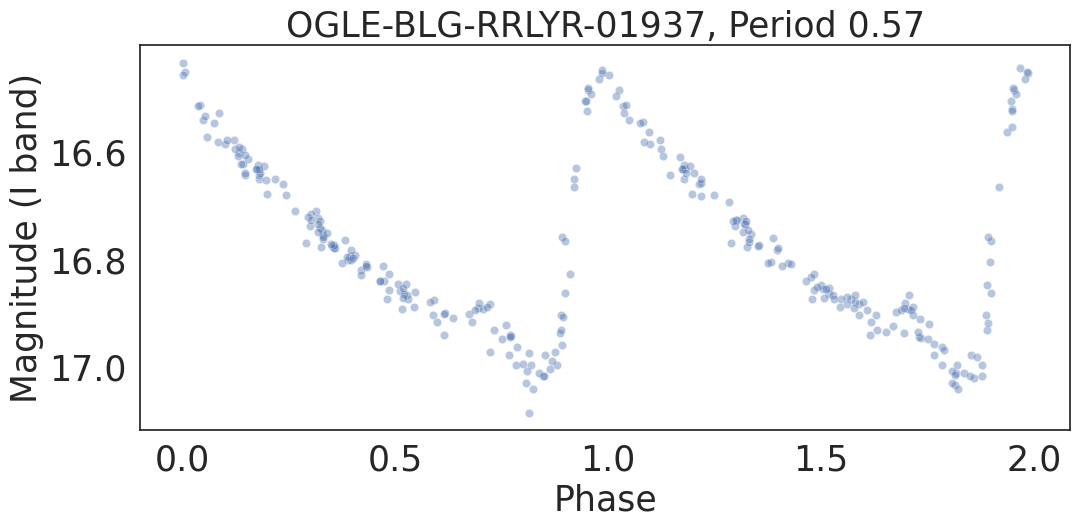

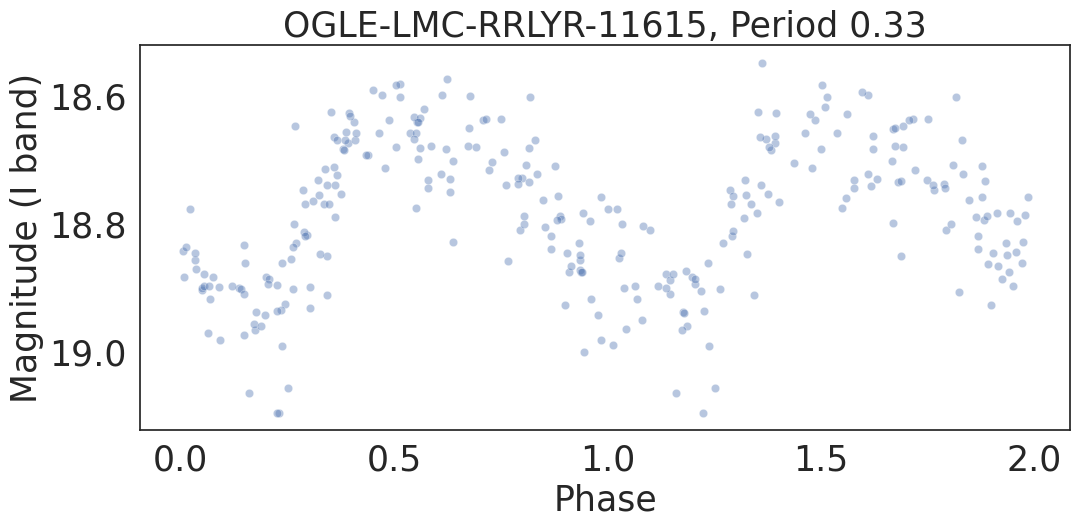

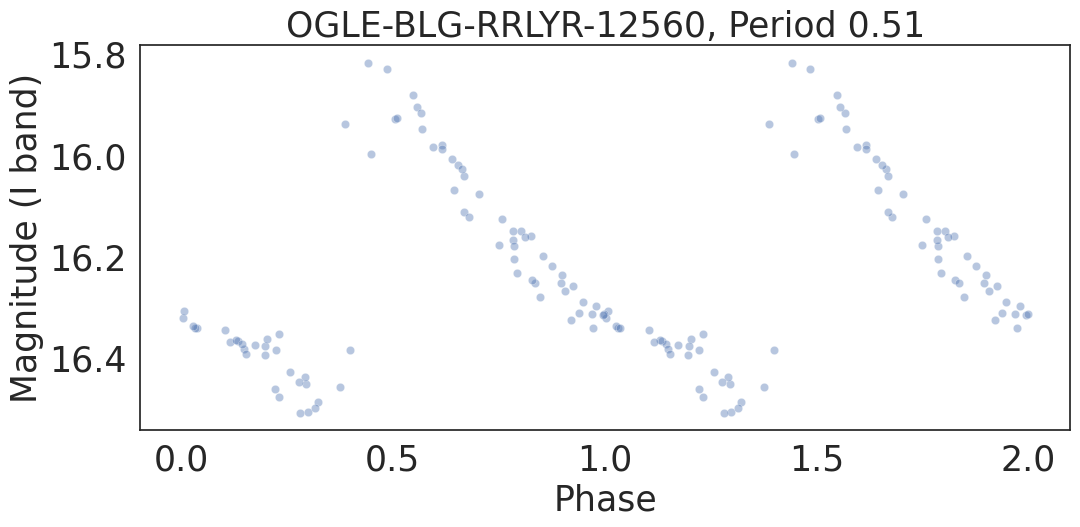

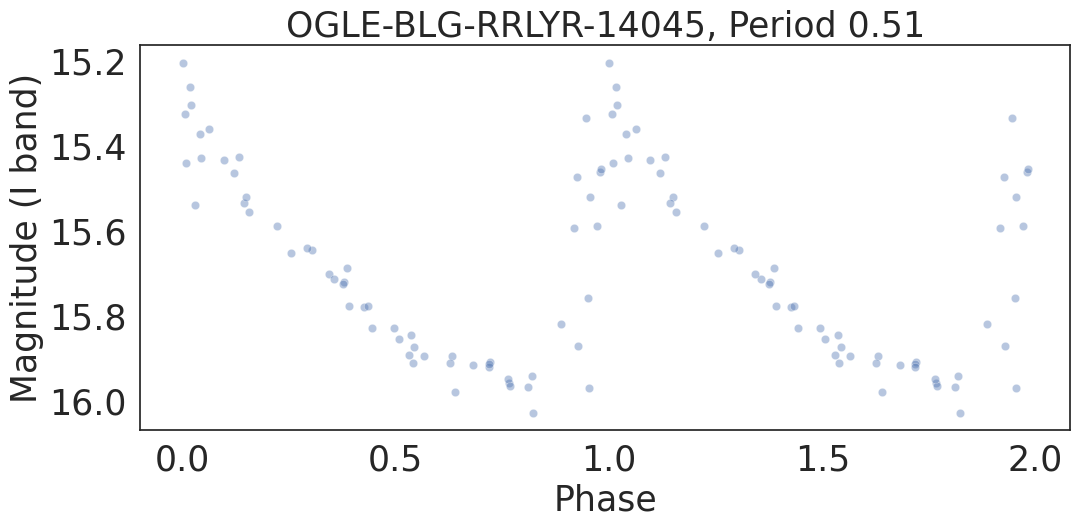

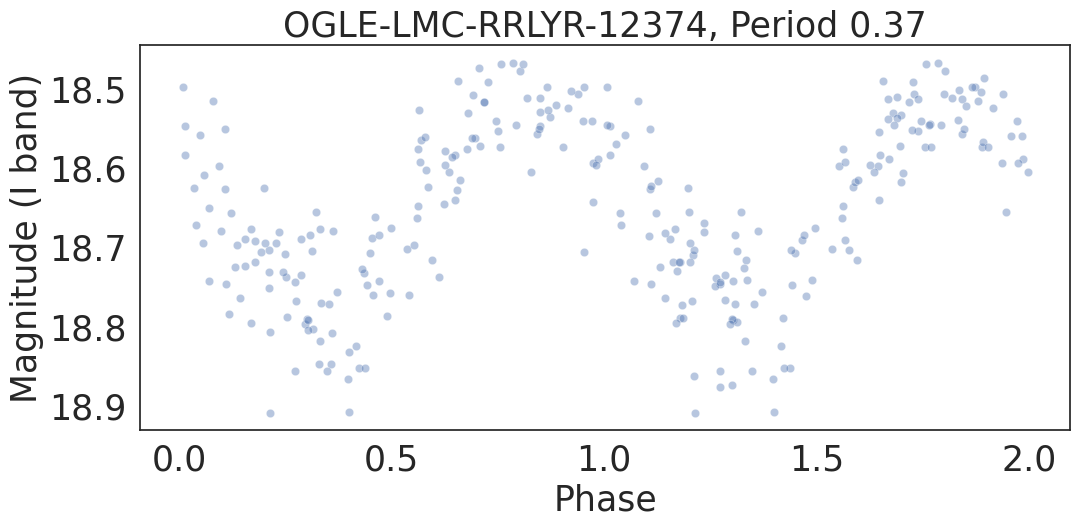

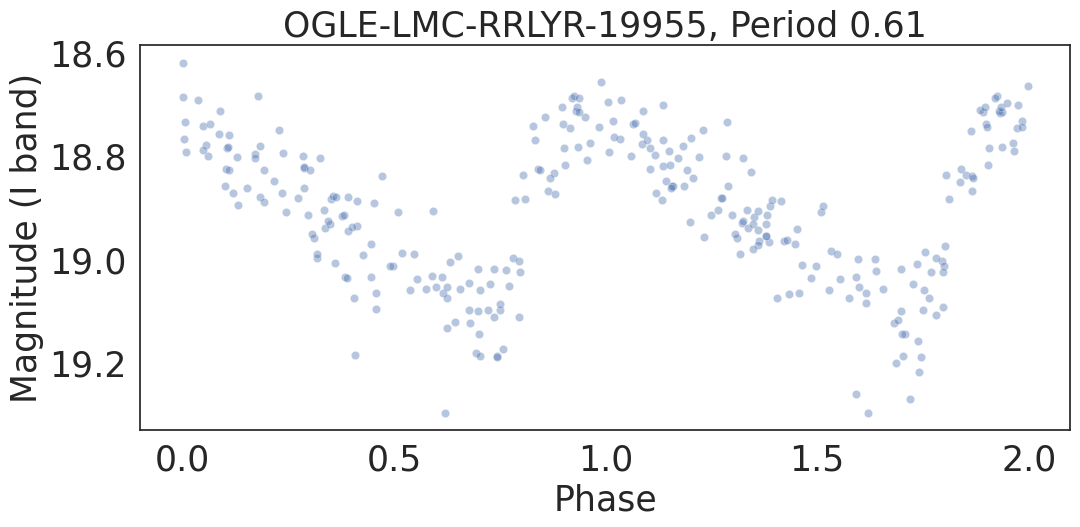

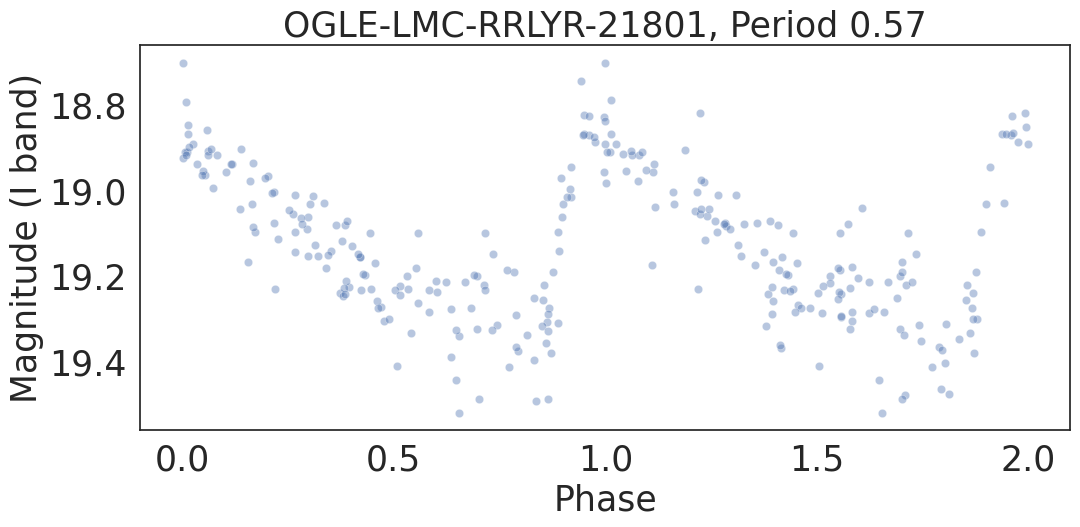

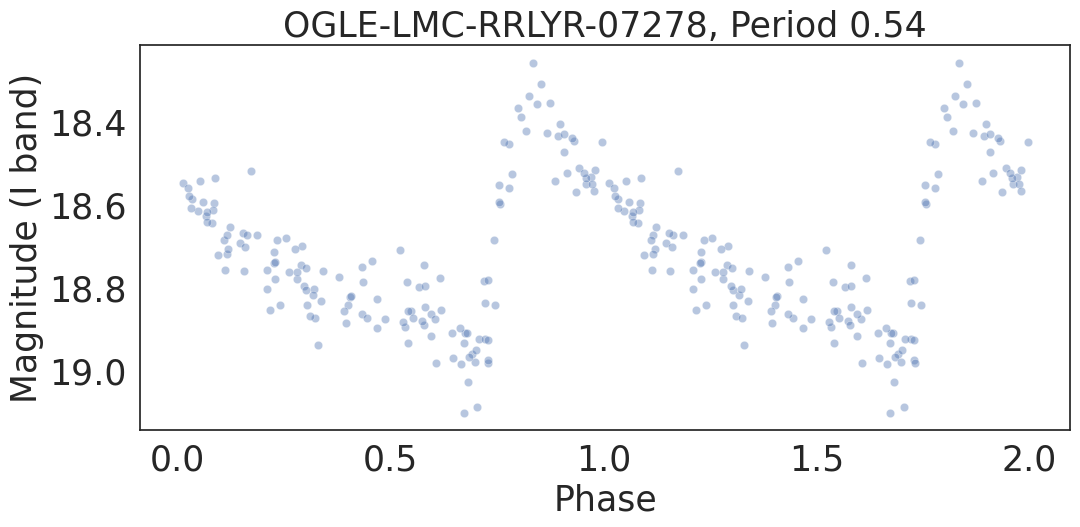

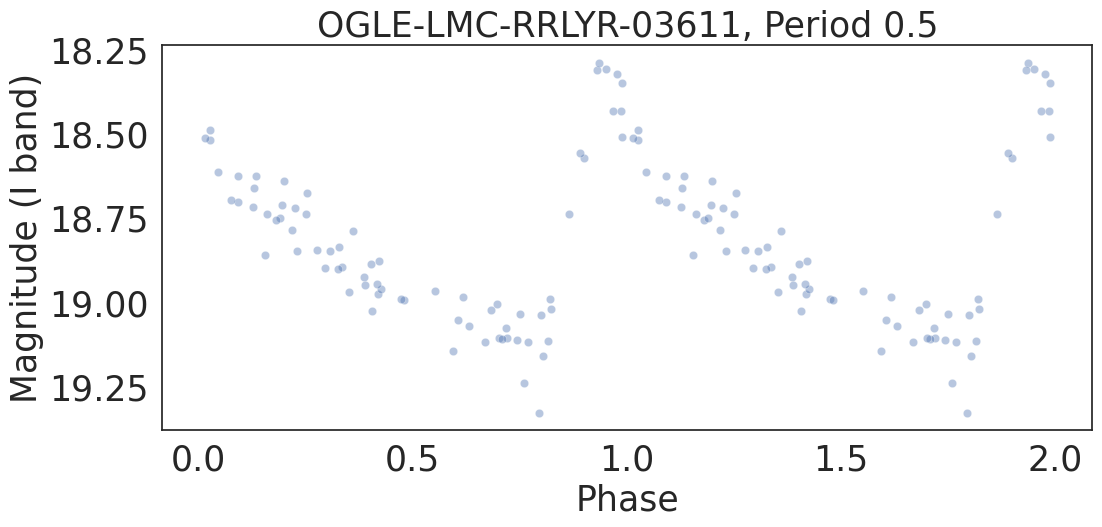

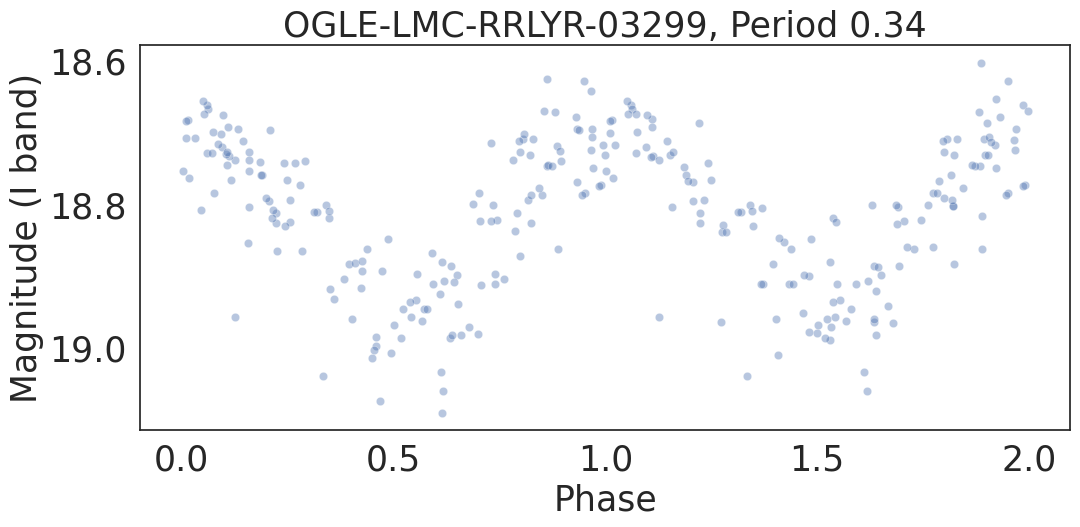

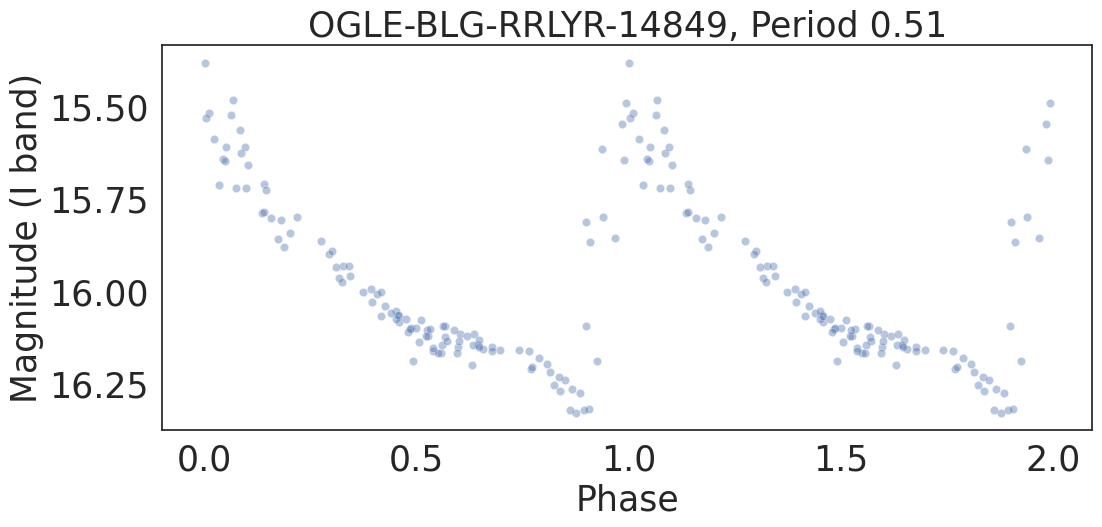

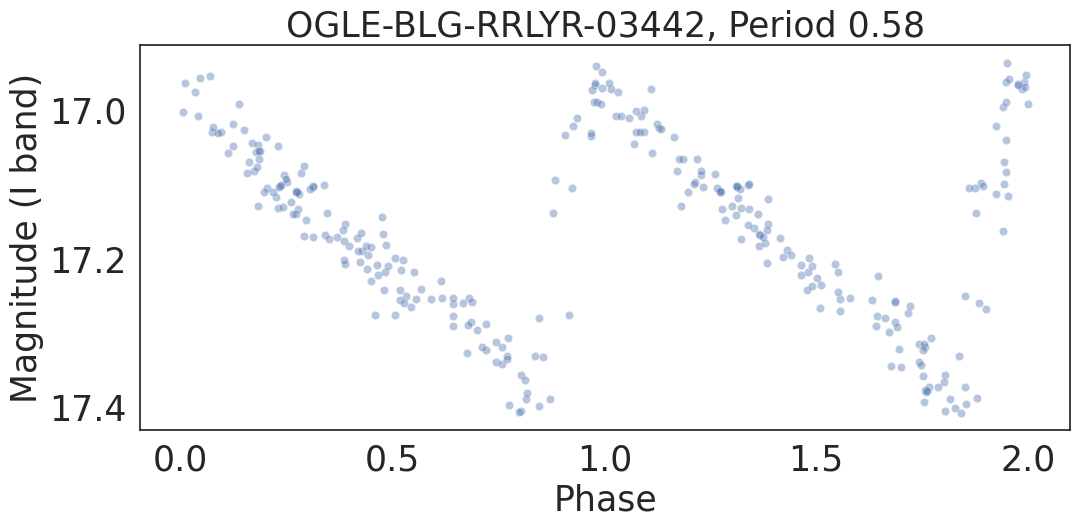

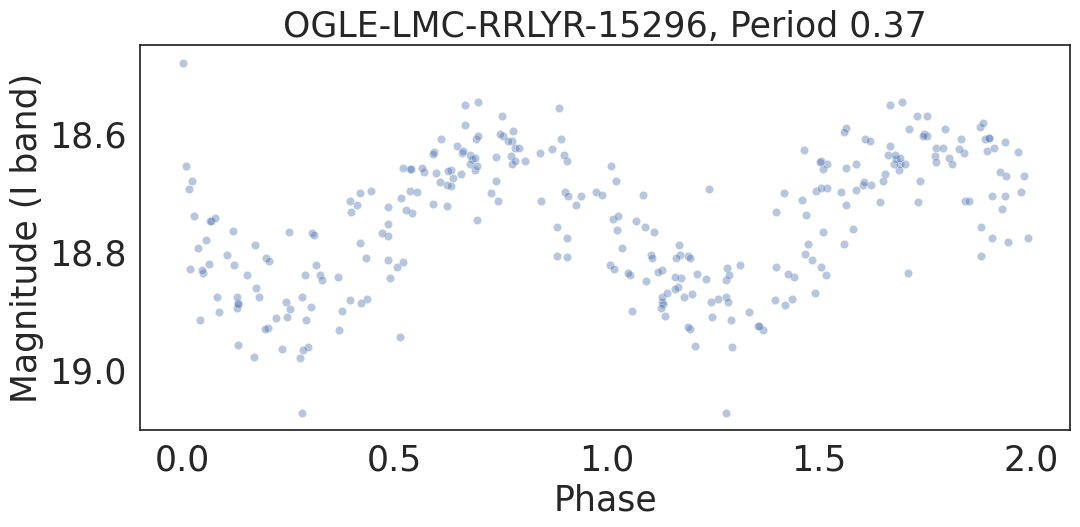

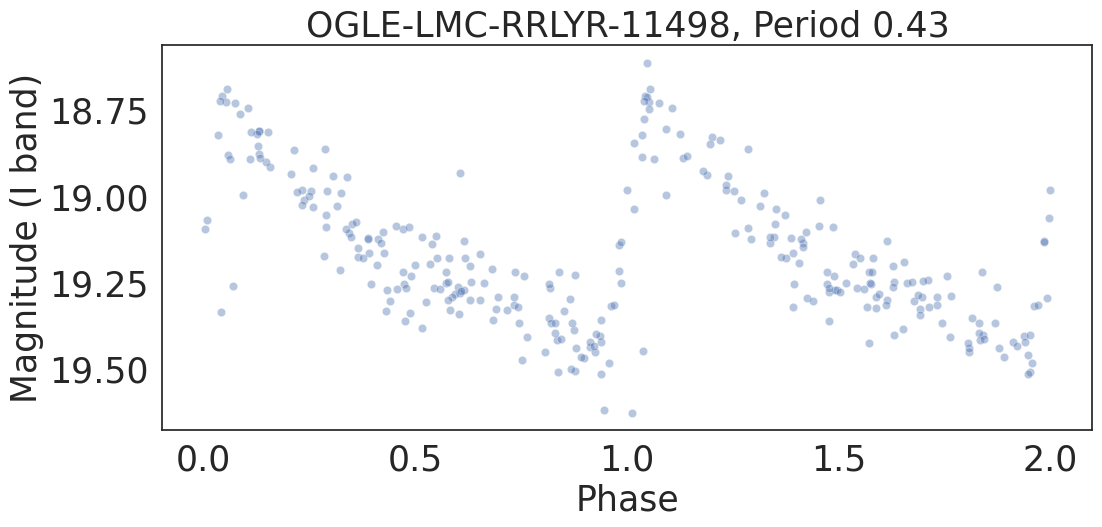

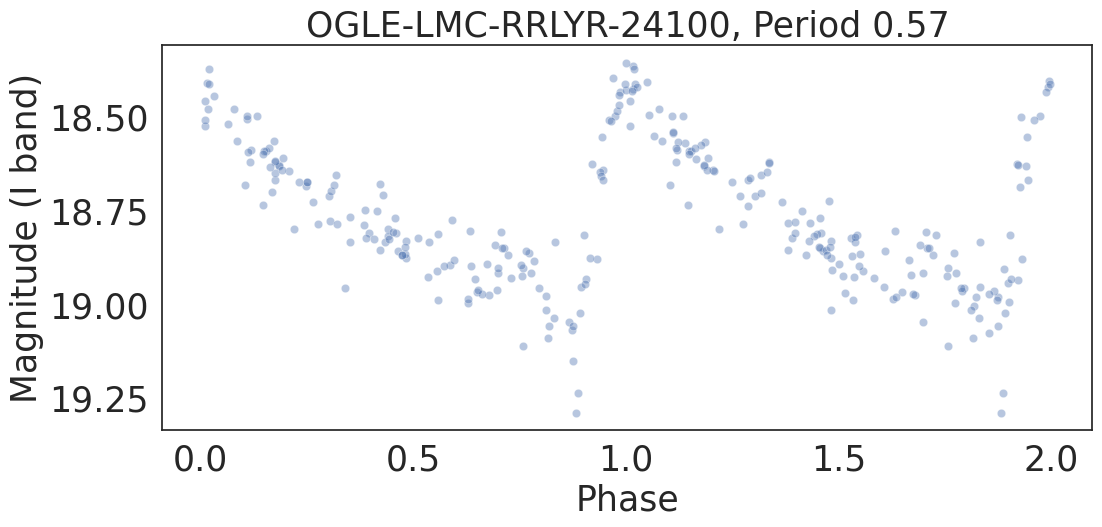

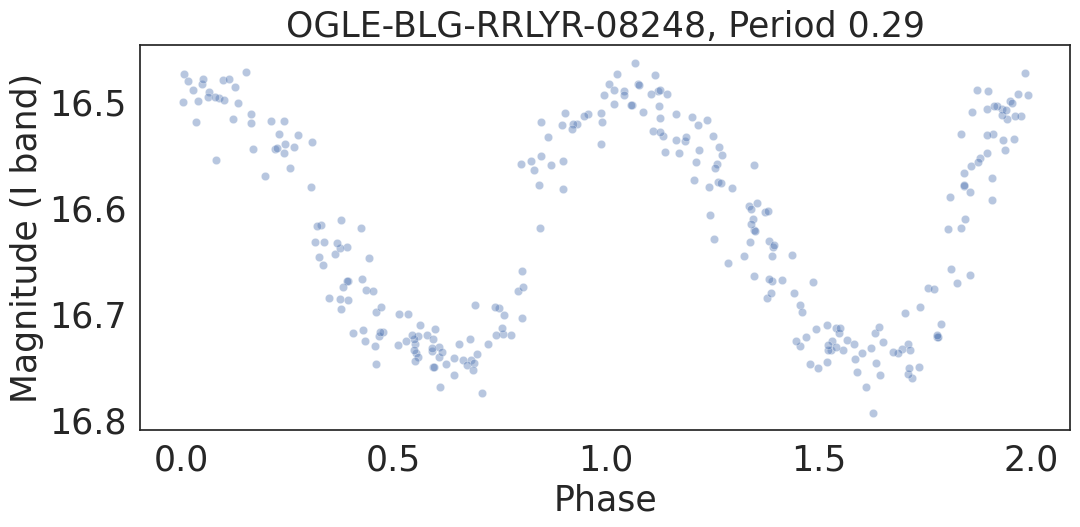

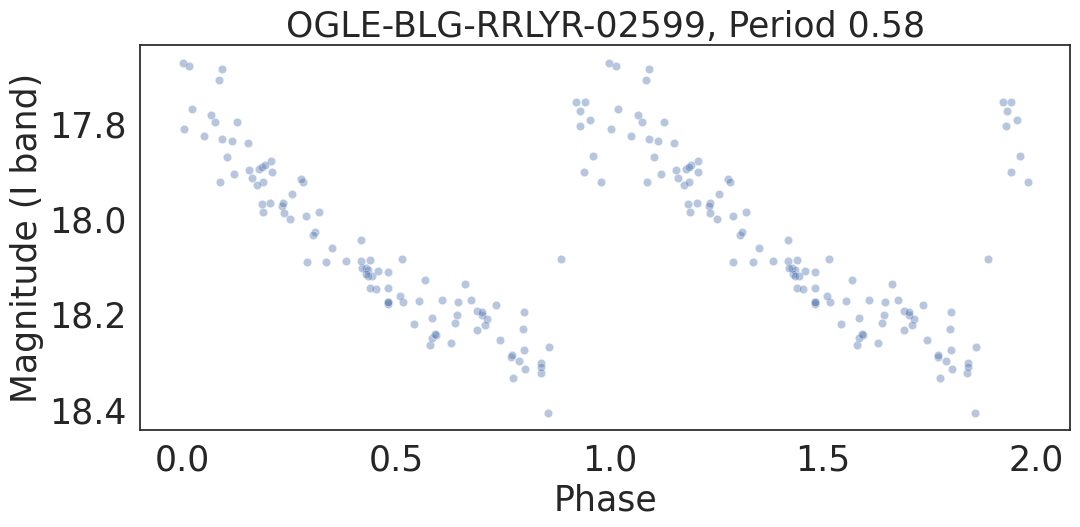

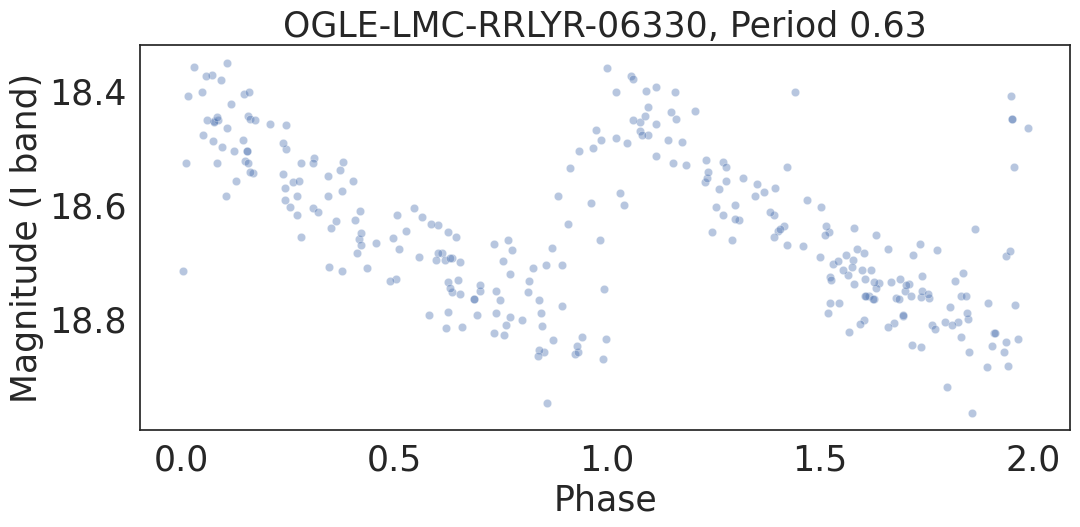

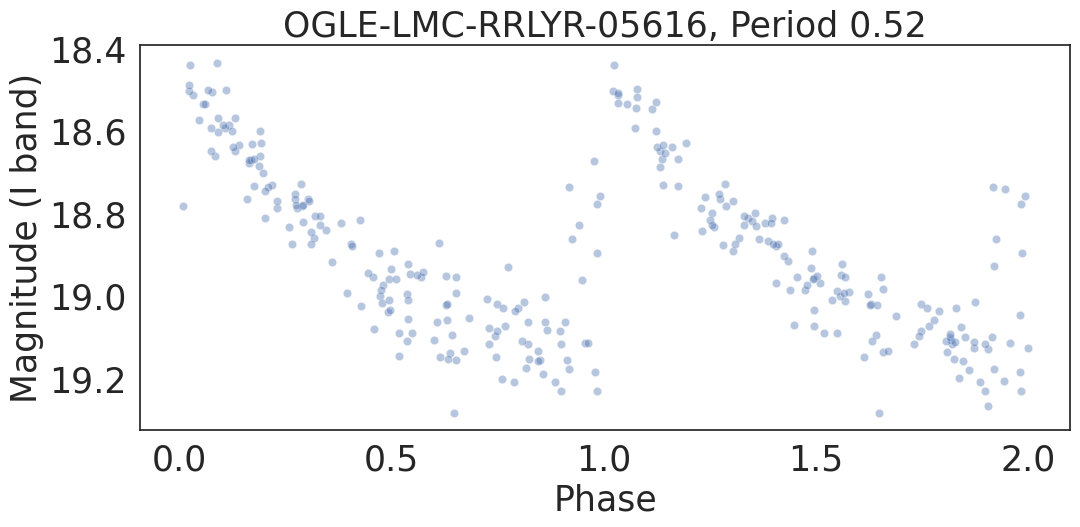

In [5]:
counter = 1 
for lc in example_train.unique():
    print(lc)
    new_train = lc_train[lc_train.ID==lc].ID.str.split("-", n = 3, expand = True)
    #print(new_train)
    period = lc_train[lc_train.ID==lc].PeriodLS.values[0]
    field = new_train[new_train.columns[1]].values[0].lower()
    lcu = pd.read_table(PATH2+field+'/'+lc.split('-')[2].lower()+'/phot/I/'+lc,sep=" ", names=['time', 'magnitude', 'error'])
    #print(lc)
    m0 = lcu.magnitude.min()
    t0 = lcu[lcu.magnitude==m0].time.min()

    lcu['Phase'] = ((lcu.time-t0)/period)%1 
    lcu = lcu.dropna()

    lcu2 =  lcu.copy()
    lcu2['Phase'] = lcu2['Phase']+1
    lcu = pd.concat([lcu,lcu2])
    
    
    sample = 300
    if lcu.dropna().shape[0]<300: 
        sample=lcu.dropna().shape[0]
    fig, ax=plt.subplots(figsize=(12, 5))
    sns.scatterplot(x="Phase", y="magnitude",
             data=lcu.dropna().sample(sample), alpha =0.4, palette = 'colorblind')
    plt.title( str(lc).replace('.dat', '') + ', Period ' + str(np.round(period,2)))
    plt.ylabel('Magnitude (I band)')

    ax.invert_yaxis()
    #plt.show()
    plt.savefig('train'+str(counter)+'.svg', format='svg', bbox_inches='tight')
    
    counter = counter + 1


In [6]:
test_dataset = pd.read_table(PATH_FEATURES_TEST, sep= ',')
train_dataset = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')


In [7]:
def delete_outliers(train_dataset, test_dataset):
    """
    Remove outliers from train and test datasets based on z-scores.

    Parameters:
        train_dataset (pd.DataFrame): Training dataset with a 'label' column.
        test_dataset (pd.DataFrame): Testing dataset with a 'label' column.

    Returns:
        tuple: The cleaned train and test datasets without outliers.
    """
    # Isolate and remove the label column from the training dataset
    train_label = train_dataset.pop('label')
    # Standardize the training dataset and compute z-scores
    train_dataset_z = (train_dataset - train_dataset.mean()) / train_dataset.std()
    filtered_entries_train = (np.abs(stats.zscore(train_dataset_z)) < 6).all(axis=1)
    train_dataset['label'] = train_label
    train_dataset = train_dataset[filtered_entries_train]

    # Isolate and remove the label column from the testing dataset
    test_label = test_dataset.pop('label')
    # Standardize the testing dataset and compute z-scores
    test_dataset_z = (test_dataset - test_dataset.mean()) / test_dataset.std()
    filtered_entries_test = (np.abs(stats.zscore(test_dataset_z)) < 6).all(axis=1)
    test_dataset['label'] = test_label
    test_dataset = test_dataset[filtered_entries_test]

    return train_dataset, test_dataset


In [8]:
train_dataset = train_dataset.ffill().bfill()
test_dataset = test_dataset.ffill().bfill()
#train_dataset, test_dataset = delete_outliers(train_dataset, test_dataset)

In [9]:
data_total = pd.concat([train_dataset, test_dataset])
y = data_total['label']
del data_total['label']

In [10]:
ID = data_total['ID']
del data_total['ID']

In [11]:
data_total= data_total.dropna()
data_total.head()

,Unnamed: 0,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,...,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,Pred,Pred2,h,e,u
0,49643,0.0435,0.131166,3,0.326667,23.686214,0.738367,0.594257,0.003356,77.820389,...,0.816054,0.779717,1.644229,2.212875,1.435421,0.999917,0.000083,0.000166,0.999336,0.583368
1,407286,0.0205,0.457675,3,0.270000,54.028838,0.549494,0.244528,0.003356,50.714320,...,0.781576,0.702489,1.650383,2.080388,1.284226,0.999914,0.000086,0.000171,0.999314,0.897967
2,106019,0.0305,0.842306,4,0.258065,18.163004,0.668703,0.655423,0.000000,6.988632,...,0.792800,0.772128,1.760809,2.357977,1.384309,0.999862,0.000138,0.000276,0.998895,0.552798
3,269038,0.0175,0.113156,2,0.350000,35.016108,0.405370,0.435593,0.006711,36098.082750,...,0.793050,0.734278,1.879023,2.721291,1.499985,0.999915,0.000085,0.000169,0.999324,0.928803
4,333084,0.0150,0.007341,1,0.273973,34.429653,0.733305,0.449642,0.000000,74.510326,...,0.770452,0.706294,1.735545,2.338960,1.432837,0.999911,0.000089,0.000177,0.999291,0.876431


In [12]:
train_dataset

,Unnamed: 0,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,...,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,Pred,Pred2,h,e,u,label
0,49643,0.04350,0.131166,3,0.326667,23.686214,0.738367,0.594257,0.003356,77.820389,...,0.779717,1.644229,2.212875,1.435421,0.999917,0.000083,0.000166,0.999336,0.583368,ClassB
1,407286,0.02050,0.457675,3,0.270000,54.028838,0.549494,0.244528,0.003356,50.714320,...,0.702489,1.650383,2.080388,1.284226,0.999914,0.000086,0.000171,0.999314,0.897967,ClassB
2,106019,0.03050,0.842306,4,0.258065,18.163004,0.668703,0.655423,0.000000,6.988632,...,0.772128,1.760809,2.357977,1.384309,0.999862,0.000138,0.000276,0.998895,0.552798,ClassB
3,269038,0.01750,0.113156,2,0.350000,35.016108,0.405370,0.435593,0.006711,36098.082750,...,0.734278,1.879023,2.721291,1.499985,0.999915,0.000085,0.000169,0.999324,0.928803,ClassB
4,333084,0.01500,0.007341,1,0.273973,34.429653,0.733305,0.449642,0.000000,74.510326,...,0.706294,1.735545,2.338960,1.432837,0.999911,0.000089,0.000177,0.999291,0.876431,ClassB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391496,329888,0.03550,0.117650,4,0.340000,272.997755,0.107475,0.054951,0.000000,2.892732,...,0.768947,1.700517,2.258444,1.387028,0.999948,0.000052,0.000104,0.999583,0.437709,ClassB
391497,251941,0.01550,0.430941,2,0.297297,17.521605,0.171918,0.861107,0.000000,22.393049,...,0.810321,1.549854,1.876412,1.352813,0.999946,0.000054,0.000107,0.999571,0.586674,ClassB
391498,29158,0.08400,0.098176,3,0.323333,161.518237,0.325507,0.084784,0.013423,5.287632,...,0.878502,2.042754,3.111463,1.564547,0.999511,0.000489,0.000978,0.996097,0.134439,ClassB
391499,139506,0.12575,0.000030,17,0.388889,0.139812,0.011606,100.287322,0.000000,3.277475,...,0.703926,1.778516,2.425085,1.367332,0.998856,0.001144,0.002284,0.990904,0.867565,ClassB


In [13]:
train_dataset['ID'] = train_dataset['ID'].str.replace('.dat', '', regex=False)
# 2. Split by '-' and expand into separate columns
split_df = train_dataset['ID'].str.split('-', expand=True)

# Assign the split columns to new dataframe columns
train_dataset['Survey'] = split_df[0]
train_dataset['Field'] = split_df[1]
train_dataset['Type'] = split_df[2]
train_dataset['ID'] = split_df[3]

test_dataset['ID'] = test_dataset['ID'].str.replace('.dat', '', regex=False)
split_df = test_dataset['ID'].str.split('-', expand=True)

# Assign the split columns to new dataframe columns
test_dataset['Survey'] = split_df[0]
test_dataset['Field'] = split_df[1]
test_dataset['Type'] = split_df[2]
test_dataset['ID'] = split_df[3]

In [14]:
star_class = 'LPV'

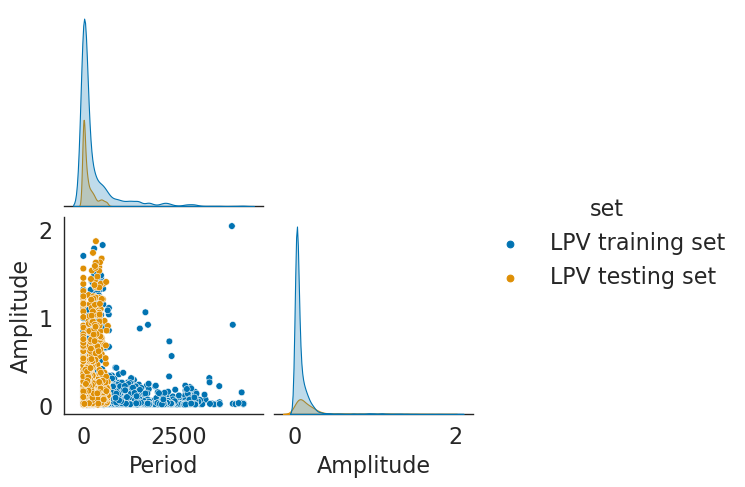

In [15]:
selected_features = ['PeriodLS', 'Amplitude']#, 'MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics_amplitude_0']
d_train = train_dataset[(train_dataset.Type==star_class) & (train_dataset.PeriodLS<train_dataset.PeriodLS.quantile(0.99))][selected_features].sample(10000)
d_test = test_dataset[(test_dataset.Type==star_class)& (test_dataset.PeriodLS<test_dataset.PeriodLS.quantile(0.99))][selected_features]
d_train['set'] = star_class + ' training set'
d_test['set'] = star_class + ' testing set'
data_final = pd.concat([d_train, d_test])
data_final.columns = ['Period', 'Amplitude', 'set']
sns.set_theme(style="white")

sns.set_context("paper", rc={"font.size":16, "font_scale":1.25, "axes.titlesize":16,"axes.labelsize":16,
                "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":16, "legend.title_fontsize": 16, 
                            "legend.loc": 'upper center', "alpha":0.2, "figure.dpi":600, 'savefig.dpi':600}) 

g = sns.pairplot(data_final, hue='set', palette = 'colorblind', corner=True)


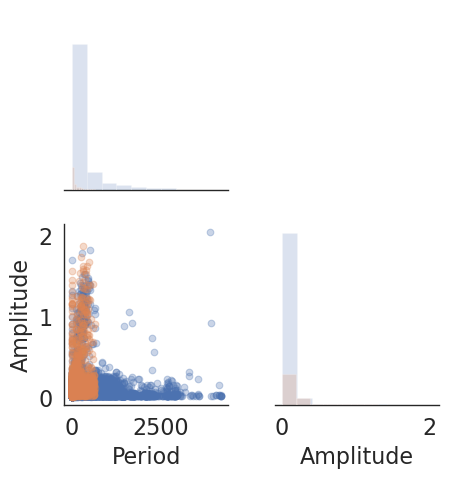

In [16]:
colors = iter(['xkcd:red purple', 'xkcd:pale teal'])

def my_scatter(x,y, **kwargs):
    plt.scatter(x,y, alpha=0.3)

def my_hist(x, **kwargs):
    plt.hist(x, alpha=0.2)

g = sns.PairGrid(data_final,  hue='set', corner=True)
g.map_diag(my_hist)
g.map_offdiag(my_scatter)

(4093, 74)


<Figure size 22500x22500 with 0 Axes>

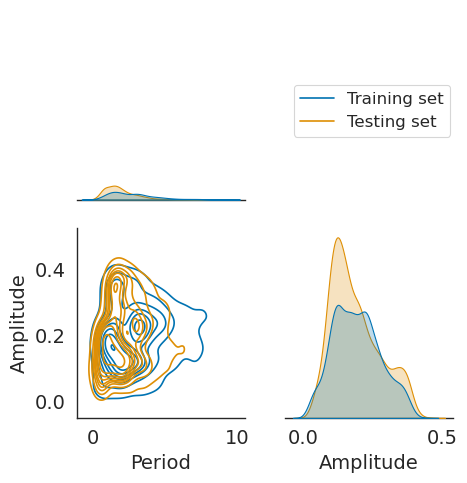

In [27]:
star_class = 'CEP'
selected_features = ['PeriodLS', 'Amplitude']#, 'MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics_amplitude_0']
limit = train_dataset[(train_dataset.Type==star_class)].PeriodLS.quantile(0.95)
print(train_dataset[(train_dataset.Type==star_class)].shape)
d_train = train_dataset[(train_dataset.Type==star_class) & (train_dataset.PeriodLS<limit)][selected_features].sample(3000)
d_test = test_dataset[(test_dataset.Type==star_class)& (test_dataset.PeriodLS<limit)][selected_features]
d_train['set'] = 'Training set'
d_test['set'] =  'Testing set'
data_final = pd.concat([d_train, d_test])
data_final.columns = ['Period', 'Amplitude', 'set']
sns.set_theme(style="white")

sns.set_context("paper", rc={"font.size":14, "font_scale":1.25, "axes.titlesize":14,"axes.labelsize":14,
                "xtick.labelsize":14, "ytick.labelsize":14, "legend.fontsize":12, "legend.title_fontsize": 14, 
                            "legend.loc": 'upper center', "alpha":0.2, "figure.dpi":600, 'savefig.dpi':600}) 

plt.figure(figsize=(25, 25), dpi = 900) 
g = sns.PairGrid(data_final, hue='set', palette = 'colorblind', corner=True)
g.map_diag(sns.kdeplot,  shade=True, palette = 'colorblind')
g.map_lower(sns.kdeplot, palette = 'colorblind')
g.map_upper(sns.kdeplot, shade=True, palette = 'colorblind', hue=None)
'''
g.axes[1,0].set_ylim((0,1))
g.axes[1,0].set_ylim((0,1.2))

g.axes[1,0].set_yticks([0, 0.2,0.4,0.6,0.8,1])
g.axes[1,0].set_xticks([0, 0.5 ,1])
'''
handles = g._legend_data.values()
labels = g._legend_data.keys()
plt.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(0, 1.8), ncol=1)
plt.savefig('cep-period-amplitude.svg', format='svg', dpi=300, bbox_inches='tight')

In [ ]:
fail

In [ ]:
train_dataset.PeriodLS.quantile(0.95)

In [ ]:
train_dataset.columns

In [ ]:
selected_features = ['PeriodLS', 'Amplitude']#, 'MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics_amplitude_0']


d_train = train_dataset[(train_dataset.Type==star_class) & (train_dataset.PeriodLS<train_dataset.PeriodLS.quantile(0.95))][selected_features].sample(1000)
d_test = test_dataset[(test_dataset.Type==star_class)& (test_dataset.PeriodLS<test_dataset.PeriodLS.quantile(0.95))][selected_features]


d_train['set'] = 'RR Lyrae training set'
d_test['set'] = 'RR Lyrae testing set'
data_final = pd.concat([d_train, d_test])
data_final.columns = ['Period', 'Amplitude', 'set']
sns.set_theme(style="white")

sns.set_context("paper", rc={"font.size":14, "font_scale":1.25, "axes.titlesize":14,"axes.labelsize":14,
                "xtick.labelsize":14, "ytick.labelsize":14, "legend.fontsize":14, "legend.title_fontsize": 14, 
                            "legend.loc": 'upper center', "alpha":0.2, "figure.dpi":600, 'savefig.dpi':600}) 


plt.figure(figsize=(25, 25), dpi = 900) 
g = sns.pairplot(data_final, palette = 'colorblind', corner=True, plot_kws=dict(s=10, edgecolor="blue",
   fc='green', linewidth=2.5, alpha=0.05))
g.axes[1,0].set_ylim((0,1))
g.axes[1,0].set_ylim((0,1.2))

g.axes[1,0].set_yticks([0, 0.2,0.4,0.6,0.8,1])
g.axes[1,0].set_xticks([0, 0.5 ,1])
plt.savefig('period-amplitude-complete.svg', format='svg', dpi=300, bbox_inches='tight')

In [ ]:
selected_features = ['PeriodLS', 'Amplitude','MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics_amplitude_0']
d_train = train_dataset[(train_dataset.Type==star_class) & (train_dataset.PeriodLS<train_dataset.PeriodLS.quantile(0.95))][selected_features].sample(1000)
d_test = test_dataset[(test_dataset.Type==star_class)& (test_dataset.PeriodLS<test_dataset.PeriodLS.quantile(0.95))][selected_features]
d_train['set'] = 'Training set'
d_test['set'] = 'Testing set'
data_final = pd.concat([d_train, d_test])
data_final.columns = ['Period', 'Amplitude','MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics', 'set']
sns.set_theme(style="white")

sns.set_context("paper", rc={"font.size":16, "font_scale":1.25, "axes.titlesize":16,"axes.labelsize":16,
                "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":16, "legend.title_fontsize": 16, 
                            "legend.loc": 'upper center', "alpha":0.2, "figure.dpi":600, 'savefig.dpi':600}) 

plt.figure(figsize=(21, 21), dpi = 900) 
g = sns.PairGrid(data_final, hue='set', palette = 'colorblind', corner=True)
g.map_diag(sns.kdeplot,  shade=True, palette = 'colorblind')
g.map_lower(sns.kdeplot, palette = 'colorblind')
g.map_upper(sns.kdeplot, shade=True, palette = 'colorblind', hue=None)

handles = g._legend_data.values()
labels = g._legend_data.keys()
plt.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 6), ncol=2, borderaxespad=0)

plt.savefig('shift.svg', format='svg', bbox_inches='tight')

In [ ]:
selected_features = ['PeriodLS', 'Amplitude','MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics_amplitude_0']
d_train = train_dataset[(train_dataset.label=='ClassA') & (train_dataset.PeriodLS<1.5)][selected_features].sample(5000)
d_test = test_dataset[(test_dataset.label=='ClassA')& (test_dataset.PeriodLS<1.5)][selected_features].sample(5000)
d_train['set'] = 'RR Lyrae training set'
d_test['set'] = 'RR Lyrae testing set'
data_final = pd.concat([d_train, d_test])
data_final.columns = ['Period', 'Amplitude','MedianAbsDev', 'Q31', 'Mean', 'Std', 'Freq1_harmonics', 'set']
sns.set_theme(style="white")

sns.set_context("paper", rc={"font.size":16, "font_scale":1.25, "axes.titlesize":16,"axes.labelsize":16,
                "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":16, "legend.title_fontsize": 16, 
                            "legend.loc": 'upper center', "alpha":0.2, "figure.dpi":600, 'savefig.dpi':600}) 

plt.figure(figsize=(21, 21), dpi = 900) 
g = sns.PairGrid(data_final, palette = 'colorblind', corner=True)
g.map_diag(sns.kdeplot,  shade=True, palette = 'colorblind')
g.map_lower(sns.scatterplot, palette = 'colorblind')

plt.savefig('shift-complete.svg', format='svg', bbox_inches='tight')

In [ ]:

PATH_FEATURES_TRAIN = PATHS['PATH_FEATURES_TRAIN']
PATH_FEATURES_TEST = PATHS['PATH_FEATURES_TEST']

lc_test = pd.read_table(PATH_FEATURES_TEST, sep= ',')
lc_train = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')

lc_test['label'] = lc_test['ID']
lc_train['label'] = lc_train['ID']

lc_train =  lc_train.drop(['Pred', 'Pred2', 'h', 'e', 'u', 'ID'], axis = 1)
lc_test =  lc_test.drop(['Pred', 'Pred2', 'h', 'e', 'u', 'ID'], axis = 1)

for col in lc_train.columns:
    if col not in ['label']:
        if lc_train[col].var()==0:
            print(col)
            del lc_train[col]
            
for col in lc_test.columns:
    if col not in ['label']:
        if lc_test[col].var()==0:
            print(col)
            del lc_test[col]

In [ ]:
#lc_train, lc_test = ut.delete_outliers(lc_train, lc_test)

In [ ]:
lc_test['set'] = 'Testing'
lc_train['set'] = 'Training'

In [ ]:
new_train = lc_train['label'].str.split("-", n = 3, expand = True) 
new_test = lc_test['label'].str.split("-", n = 3, expand = True) 

lc_train["Field"]= new_train[1] 
lc_train['Class']= new_train[2]  

lc_test["Field"]= new_test[1] 
lc_test['Class']= new_test[2] 


total_set = pd.concat([lc_train, lc_test])
total_set['count'] = 1

total_set= total_set[['set', 'Class', 'count']].groupby(['set', 'Class']).sum().reset_index()